<a href="https://www.kaggle.com/code/aneevinay/ps5e10-accident-risk?scriptVersionId=270923426" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# ** PREDICTING ROAD ACCIDENTS RISK - REGRESSION PROBLEM **

# Introduction

> This data science project is a part of https://www.kaggle.com/competitions/playground-series-s5e10 .It aims to predict road accident risk by applying machine learning methods. The objective is to predict risk level of road by analyzing their factors. The project involves preprocessing ,categorical encoding the train and test data , and apply regression machine learning model xgb regressor. EDA analysis was done in sepearate notebook https://www.kaggle.com/code/aneevinay/ps5e10-accident-risk-eda. 

# Loading the Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint,uniform
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

# Read the Dataset

In [2]:
train_path = '/kaggle/input/playground-series-s5e10/train.csv'
test_path = '/kaggle/input/playground-series-s5e10/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Check the Data

In [3]:
def dataset_summary(datasets):
    summary = []

    for name, df, path in datasets:
        size_on_disk = os.path.getsize(path) / (1024 * 1024)  # MB
        size_in_memory = df.memory_usage(deep=True).sum() / (1024 * 1024)  # MB
        rows, cols = df.shape

        summary.append({
            "Dataset": name,
            "Size on Disk (MB)": round(size_on_disk, 2),
            "Size in Memory (MB)": round(size_in_memory, 2),
            "# of Rows": rows,
            "# of Cols": cols
        })

    return pd.DataFrame(summary)


In [4]:
datasets = [
    ("train", train, train_path),
    ("test", test, test_path)
]

dataset_summary(datasets)

,Dataset,Size on Disk (MB),Size in Memory (MB),# of Rows,# of Cols
0,train,36.18,149.94,517754,14
1,test,11.29,48.66,172585,13


## Glimpse the Data

In [5]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [6]:
test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


## Check missing values

In [7]:
train.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

> There is no missing values in the train dataset

In [8]:
train.duplicated().sum()

0

> There is no duplicated values in the dataset. That means the dataset is clean

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

## Data unbalance

### Data Type 

In [10]:
pd.concat([train.drop('target', axis=1, errors='ignore').dtypes, 
           test.dtypes], axis=1, keys=['train', 'test'])

,train,test
id,int64,int64
road_type,object,object
num_lanes,int64,int64
curvature,float64,float64
speed_limit,int64,int64
lighting,object,object
weather,object,object
road_signs_present,bool,bool
public_road,bool,bool
time_of_day,object,object


### Statistical Comparison

In [11]:
train.describe().T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
id,258876.500000,149462.849974,0.0,517753.0
num_lanes,2.491511,1.120434,1.0,4.0
curvature,0.488719,0.272563,0.0,1.0
speed_limit,46.112575,15.788521,25.0,70.0
num_reported_accidents,1.187970,0.895961,0.0,7.0
accident_risk,0.352377,0.166417,0.0,1.0


In [12]:
test.describe().T[['mean', 'std', 'min', 'max']]

,mean,std,min,max
id,604046.000000,49821.142441,517754.0,690338.0
num_lanes,2.494046,1.119148,1.0,4.0
curvature,0.487263,0.272343,0.0,1.0
speed_limit,46.102761,15.787077,25.0,70.0
num_reported_accidents,1.186059,0.897161,0.0,7.0


### Visual Distribution Comparison

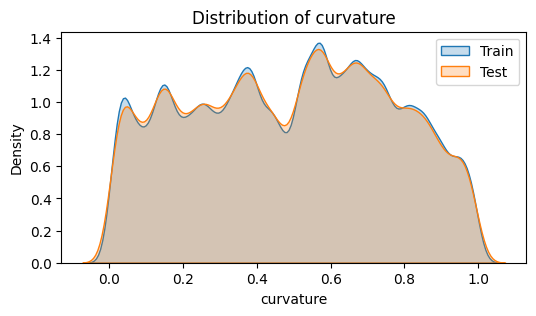

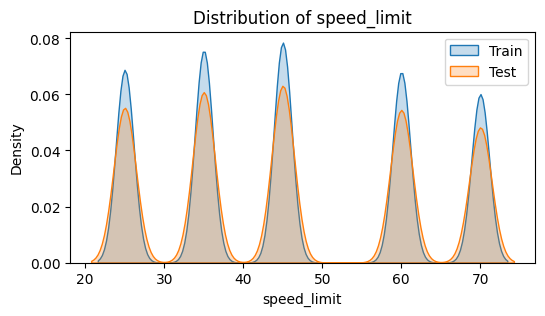

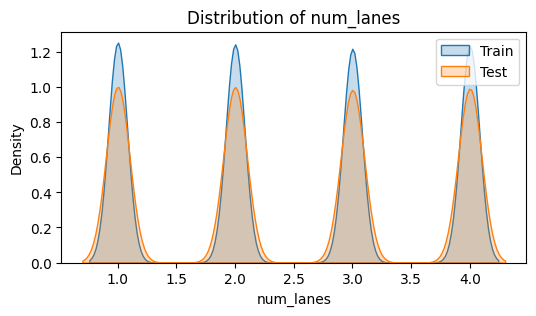

In [13]:
cols = ['curvature', 'speed_limit', 'num_lanes']  

for col in cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(train[col], label='Train', fill=True)
    sns.kdeplot(test[col], label='Test', fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

> both train data and test data are very similar

> Here the target variable is accident_risk . To check target distribution ,plot histogram

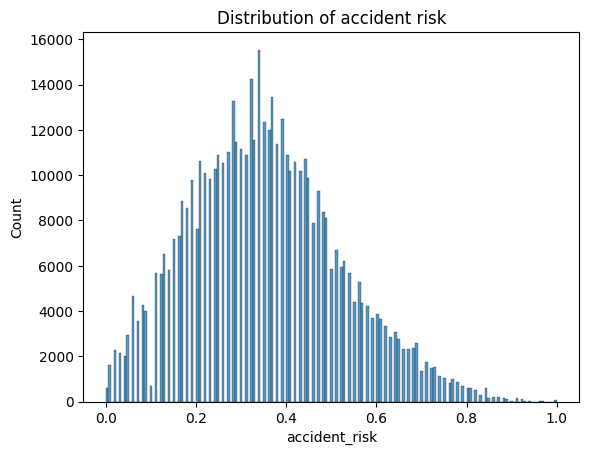

In [14]:
sns.histplot(x='accident_risk',data=train)
plt.title('Distribution of accident risk')
plt.show()

> The histplot is normal bell shaped structure and right skewed. It have long tail near 1.0 showing outliers.it can distroy the training  

In [15]:
train['accident_risk'].skew()

0.37841797634228086

> That means it is not heavily skewed.

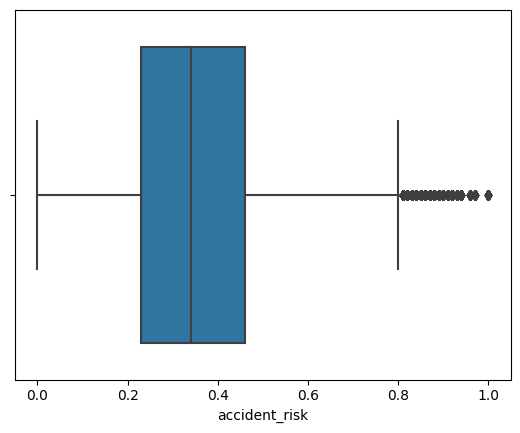

In [16]:
sns.boxplot(x='accident_risk',data=train)
plt.show()

> There are booliean columns which have true/false values and we want to convert into 1/0 using map function.

In [17]:
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in bool_cols:
    train[col] = train[col].map({True: 1, False: 0}) 
    test[col] = test[col].map({True: 1, False: 0}) 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  int64  
 8   public_road             517754 non-null  int64  
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  int64  
 11  school_season           517754 non-null  int64  
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: float64(2), int64

# Predictive models

## Feature Engineering

> from data exploration, some features have no direct impact on accident_risk but they can't be removed .so it is better to create new features

train['road_lane_type'] = train['road_type'].astype(str) + '_' + train['num_lanes'].astype(str)
train['road_public_combo'] = train['road_type'].astype(str) + '_' + train['public_road'].astype(str)
train['holiday_school'] = train['holiday'].astype(str) + '_' + train['school_season'].astype(str)
train['sign_lane_interaction'] = train['road_signs_present'].astype(str) + '_' + train['num_lanes'].astype(str)

## categorical encodding

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  int64  
 8   public_road             517754 non-null  int64  
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  int64  
 11  school_season           517754 non-null  int64  
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: float64(2), int64

In [19]:
train.nunique()

id                        517754
road_type                      3
num_lanes                      4
curvature                    261
speed_limit                    5
lighting                       3
weather                        3
road_signs_present             2
public_road                    2
time_of_day                    3
holiday                        2
school_season                  2
num_reported_accidents         8
accident_risk                 98
dtype: int64

In [20]:
ohe=OneHotEncoder(drop=None, handle_unknown='ignore')
cat_cols=train.select_dtypes(include='object').columns.tolist()
encoded_data=ohe.fit_transform(train[cat_cols]).toarray()
encoded=pd.DataFrame(encoded_data,columns=ohe.get_feature_names_out(cat_cols))
train_numeric=train.drop(columns=cat_cols)
train=pd.concat([train_numeric.reset_index(drop=True),
                       encoded.reset_index(drop=True)],axis=1)

cat_cols = [
    'road_type', 'lighting', 'weather', 'time_of_day',
    'road_lane_type', 'road_public_combo', 'holiday_school', 'sign_lane_interaction'
]

for col in cat_cols:
    train[col] = train[col].astype('category')


## Define Predictors and target values

In [21]:
X=train.drop(columns=['id','accident_risk'],axis=1)
y=train['accident_risk']

In [22]:
scaler=StandardScaler()
X_cols=X.columns
X=scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)

## Split Data in train,test and validation set

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

## Comparison of models

models=[LinearRegression(),   
       DecisionTreeRegressor(),    
        RandomForestRegressor(),    
        XGBRegressor()]    
for model in models:    
    scores=cross_val_score(model,X,y,cv=5,scoring='neg_root_mean_squared_error')    
    cv_rmse=scores.mean()    
    print(f"Average CV RMSE for {model.__class__.__name__}: {cv_rmse:.4f}")    
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE of {model.__class__.__name__}: {rmse}")

Average CV RMSE for LinearRegression: -0.0735    
RMSE of LinearRegression: 0.07308136140094891   
Average CV RMSE for DecisionTreeRegressor: -0.0829    
RMSE of DecisionTreeRegressor: 0.08200897748090723     
Average CV RMSE for RandomForestRegressor: -0.0595   
RMSE of RandomForestRegressor: 0.05931964103321271    
Average CV RMSE for XGBRegressor: -0.0562    
RMSE of XGBRegressor: 0.056174869479945565    

> Lower RMSE is the best model that means XGBRegressor.now finalizing the model with XGBREgressor

In [24]:
baseline_model = XGBRegressor(random_state=42, n_jobs=-1)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

print("🔹 Baseline Model Results")
print("RMSE:", mean_squared_error(y_test, y_pred_base, squared=False))

🔹 Baseline Model Results
RMSE: 0.05606988543802257


## Hyperparameter tuning

params = {
    'n_estimators': randint(100,1000),
    'learning_rate': uniform(0.01,0.2) ,
    'max_depth': randint(3,10),
    'subsample':  [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 0.1, 1.0, 5.0],
    'min_child_weight': [1, 3, 5, 7]
}

xgb = XGBRegressor(random_state=42)
search = RandomizedSearchCV(xgb, params, cv=3, scoring='neg_root_mean_squared_error', n_iter=15, verbose=1, n_jobs=2)
print("\n🔹 Starting Randomized Search (this may take several minutes)...")
search.fit(X, y)

print("Best Parameters:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.07392885692149528, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 634, 'reg_lambda': 5.0, 'subsample': 1.0}
Best CV RMSE: 0.05615524061018767

In [25]:
best_params = {
    'colsample_bytree': 1.0, 
    'learning_rate': 0.07392885692149528,
    'max_depth': 6,
    'min_child_weight': 7,
    'n_estimators': 634, 
    'reg_lambda': 5.0,
    'subsample': 1.0
}

xgb=XGBRegressor(tree_method='hist',
    #enable_categorical=True,
    random_state=42)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE : {rmse}")

RMSE : 0.05606988543802257


# Submission

## Final Model-XGBRgressor

In [26]:
xgb.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

lighting_night            0.498402
speed_limit               0.205218
weather_clear             0.135972
curvature                 0.121204
num_reported_accidents    0.031154
weather_foggy             0.001832
weather_rainy             0.000945
holiday                   0.000768
public_road               0.000753
lighting_daylight         0.000624
lighting_dim              0.000388
time_of_day_evening       0.000361
num_lanes                 0.000337
road_signs_present        0.000334
time_of_day_morning       0.000317
school_season             0.000288
road_type_urban           0.000288
road_type_rural           0.000287
time_of_day_afternoon     0.000267
road_type_highway         0.000260
dtype: float32


import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(train)
shap.summary_plot(shap_values, train)

# Predict on Test Data 

In [28]:
cat_cols=test.select_dtypes(include='object').columns.tolist()
encoded_data=ohe.fit_transform(test[cat_cols]).toarray()
encoded_test=pd.DataFrame(encoded_data,columns=ohe.get_feature_names_out(cat_cols))
test_numeric=test.drop(columns=cat_cols)
test=pd.concat([test_numeric.reset_index(drop=True),
                       encoded_test.reset_index(drop=True)],axis=1)

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   num_lanes               172585 non-null  int64  
 2   curvature               172585 non-null  float64
 3   speed_limit             172585 non-null  int64  
 4   road_signs_present      172585 non-null  int64  
 5   public_road             172585 non-null  int64  
 6   holiday                 172585 non-null  int64  
 7   school_season           172585 non-null  int64  
 8   num_reported_accidents  172585 non-null  int64  
 9   road_type_highway       172585 non-null  float64
 10  road_type_rural         172585 non-null  float64
 11  road_type_urban         172585 non-null  float64
 12  lighting_daylight       172585 non-null  float64
 13  lighting_dim            172585 non-null  float64
 14  lighting_night      

In [30]:
test_ids = test['id'].copy()

#test['road_lane_type'] = test['road_type'].astype(str) + '_' + test['num_lanes'].astype(str)
#test['road_public_combo'] = test['road_type'].astype(str) + '_' + test['public_road'].astype(str)
#test['holiday_school'] = test['holiday'].astype(str) + '_' + test['school_season'].astype(str)
#test['sign_lane_interaction'] = test['road_signs_present'].astype(str) + '_' + test['num_lanes'].astype(str)

test_model = test.drop(columns=['id'], errors='ignore') 
test_model = pd.DataFrame(scaler.transform(test_model), columns=X_cols)
test_model = test_model.reindex(columns=X.columns, fill_value=0)


#for col in cat_cols:
  #  if col in test.columns:
  #      test[col] = test[col].astype('category')

# Drop unused columns (same as in training)
#test_model = test.drop(columns=['id','road_type','num_lanes','road_signs_present','public_road','holiday','school_season'], errors='ignore')

# Reindex to match training feature order
#test_model = test_model.reindex(columns=X.columns, fill_value=0)
        
y_pred = xgb.predict(test_model)

submission = pd.DataFrame({
    'id': test_ids,
    'accident_risk': y_pred
})

submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!


In [31]:
import joblib

joblib.dump(xgb, "model.pkl", compress=3)

['model.pkl']